## Importing all the necessary libraries 

In [114]:
import numpy as np
import pandas as pd
# for inline plots in jupyter
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# settings for seaborn plotting style
sns.set(color_codes=True)


## Importing data

In [5]:
trns_data = pd.read_csv('C:/Users/FUN/Downloads/datasciencetest-master/transData.csv',header = 0)

In [6]:
testsample_data = pd.read_csv('C:/Users/FUN/Downloads/datasciencetest-master/testSamples.csv',header = 0)


## Data Validation
__Before going ahead with analysis lets check if there are any 'null' values in any columns of both the datasets.__

In [121]:
print(trns_data.isnull().sum())

print(testsample_data.isnull().sum())

transaction_id        0
sample_id             0
transaction_type      0
transaction_amount    0
dtype: int64
sample_id     0
test_group    0
dtype: int64


### Checking for outliers and Inter quartile range

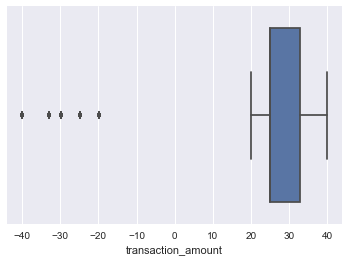

In [68]:
ax = sns.boxplot(x=trns_data['transaction_amount'])

*__Observation__ : Box-plots presents the variability and spread of the data. If we look at the box-plot we can notice that there are couple of outliers. The middle half of a data set falls within the interquartile range which is 8 (Q3$-$Q1).*

### Let's check the frequency distribution of the variable test_group
#### 0 = control group and 1 = test group

In [8]:
testsample_data.groupby('test_group').count()

,sample_id
test_group,
0,44886
1,14835


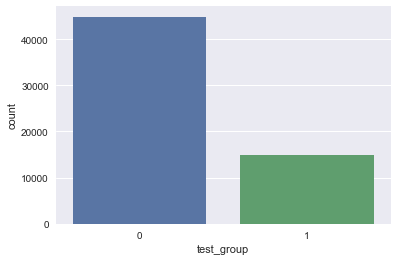

In [37]:
sns.countplot(x=testsample_data['test_group'])


#### We can clearly notice in the below visualization that there are more number of people in the control group than the test group

#### We have seen the frequency but lets calculate the probability distribution of both the groups

In [11]:
def probability_frequency_distribution(df , col):
    class_prob = pd.DataFrame(df[col].value_counts()/len(df))
    return class_prob


In [49]:
probability_frequency_distribution(testsample_data, 'test_group')


,test_group
0,0.751595
1,0.248405


## Rationale behind inner-joining the two dataframes
#### As per our objective we are mainly focused on the people who call in to cancel and the variables required to answer our questions are presented in the transactional data.

  -  Note - “Inner join produces only the set of records that match in both transactional data and Test sample data.”


In [47]:
#Inner-joining two dataframes
full_data = pd.merge(trns_data, testsample_data, on='sample_id', how='inner')
full_data.head()

,transaction_id,sample_id,transaction_type,transaction_amount,test_group
0,52346326,11,REBILL,24.95,1
1,52346327,11,REBILL,24.95,1
2,52346328,32,REBILL,29.95,1
3,52346329,32,REBILL,29.95,1
4,52346330,32,REBILL,29.95,1


### Outlier detection and Interpretation

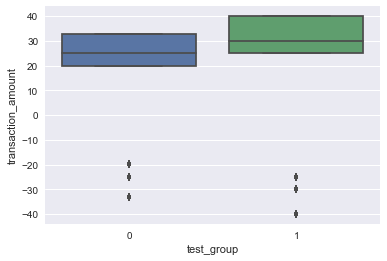

In [72]:
ax = sns.boxplot(x=full_data['test_group'],y=full_data['transaction_amount'])

*__Observation__: The outliers are present in both the groups. The average transaction amount for users who use web page to cancel is $25 and average transaction amount for users who call in is $30.

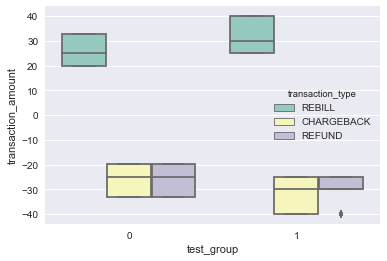

In [71]:
ax = sns.boxplot(x=full_data['test_group'],y=full_data['transaction_amount'],hue=full_data['transaction_type'],palette="Set3")

*__Observation__: We can clearly see in the above boxplots that all the outliers are generated from the users who call in for a refund.*

## Let's check which group generates more revenue
#### Now the feature 'transaction_type' is a categorical column having 3 categories which are 'REBILL', 'CHARGEBACK' and 'REFUND'
#### Observations  
  -  Revenue is generated only through 'REBILL' hence the other categories are filtered out
  -  From a frequentist perspective we can notice that there is no significant difference between two groups in terms of revenue generation
  

In [117]:
rev_per_group=pd.DataFrame(full_data[full_data['transaction_type']=='REBILL'].groupby('test_group')['transaction_amount'].sum())
rev_per_group

,transaction_amount
test_group,
0,97359.20
1,100869.75


[Text(0,0,'0'), Text(0,0,'1')]

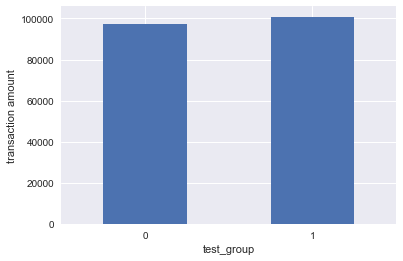

In [133]:
#df.boxplot('transaction_amount',by='test_group')
plt = rev_per_group.plot.bar(legend = False)
plt.set_ylabel("transaction amount")
labels=['0','1']
plt.set_xticklabels(labels, rotation = 360)


### Let's back our assumptions with an independent t-test
#### Now, why independent t-test?
  -  We are comparing the means between two groups in order to determine whether there is statistical evidence that the associated population means are significantly different
  -  We have one continuous variable('transaction_amount') and one categorical variable with 2 groups.

#### Null Hypothesis - There is no significant difference between the groups in terms of revenue generation
$Ho$ = mean of group1 equal to mean of group2


#### Alternate Hypothesis - There is a significant difference between the groups in terms of revenue generation.
$Ha$ = mean of group1 not equal to mean of group2


In [16]:
# Importing t-test function from scipy.stats
from scipy.stats import ttest_ind
ttest_ind(full_data.transaction_amount[full_data.test_group == 0],full_data.transaction_amount[full_data.test_group == 1])

Ttest_indResult(statistic=-17.61637445019746, pvalue=4.410306919832482e-68)

*__Interpretation__ : So, if we notice the t-test gave us the P-value which is less than 0.05. Now we can reject our null hypothesis and accept our alternate hypothesis which means the means of both the groups are not equal and there is a significant difference in the revenue generation between the groups.*

### Who produces higher chargeback rate? user who calls in or user who uses the web page?
__Given:__ CHARGEBACK RATE = CHARGEBACK's $/$ REBILL's

In [35]:
def chargeback_rate(df,col1,col2):
    chargeback_rate=df[df[col1]=='CHARGEBACK'].groupby(col2).count()/df[df[col1]=='REBILL'].groupby(col2).count()
    return (pd.DataFrame(chargeback_rate[col1]))

In [36]:
chargeback_rate(full_data,'transaction_type','test_group')


,transaction_type
test_group,
0,0.028222
1,0.017785


*__Observation__ - If we notice the distribution of the data the users that use webform to cancel are way higher than the users who call in to cancel the subscription. But, when we look at the chargeback rate the users that use web form has a higher chargeback rate compared to the users that call in to cancel the subscription*

### Let's check if the users who call in has more chance to resubscribe.
#### Approach : The idea is to create a 2x2 table where we can run a chi-square test to check the statistical significance.
*Note: A new variable is generated from transaction_type variable where 'REBILL's' are coded as '1' and others '0'. A 3x2 table is also generated to check whether there will be any significant difference in the results compared to 2x2 and found that there is no significant difference in the results.*


In [53]:
def Rebill_grp(x):
    if x['transaction_type'] == 'REBILL' :
        return '1'
    else:
        return '0'

In [54]:
full_data['Rebill_grp'] = full_data.apply(lambda x: Rebill_grp(x),axis=1)

In [74]:
table = pd.crosstab(full_data['test_group'],full_data['Rebill_grp'])
table

Rebill_grp,0,1
test_group,,
0,294,3756
1,175,3205


#### Alternate Hypothesis - There is a relationship between the test group (users who call in) and likeliness of them to resubscribe
*The $Ha$ represents the change or difference in the situation*
#### Null Hypothesis - There is no relationship between the test group (users who call in) and likeliness of them to resubscribe
*The $Ho$ represents there is no change or no difference in the situation*.

In [75]:
from scipy.stats import chi2_contingency
chi2,p,dof,expected = chi2_contingency(table.values)
print ('Chi-square statistic %0.3f P-value %0.3f Degrees of freedom %0.3f' % (chi2, p,dof))

Chi-square statistic 13.151 P-value 0.000 Degrees of freedom 1.000


*__Interpretation__: We are looking for P-value greater than 0.05 in order to conclude that the variables are independent of one another. Based on our result it is clear that our P-value is less than 0.05, and hence we can reject our null hypothesis and conclude that they are co-related/ there is a relationship between the users who call in and likeliness of them re-subscribing.*

### Some additional insights 

In [111]:
##Filtering out the users who web page and took an extra subscription (who are rebilled).
control_rebill=full_data[(full_data['transaction_type']=='REBILL')& (full_data['test_group'] == 0)]
##Counting users who took more than one subscription
control_sub=control_rebill['sample_id'].value_counts()[control_rebill['sample_id'].value_counts()>1]
##Output
control=pd.DataFrame({'sample_id':control_sub.index, 'count_of_sample_id':control_sub.values})
control

,count_of_sample_id,sample_id
0,22,5493
1,19,11424
2,18,31411
3,18,27713
4,18,24907
5,18,49077
6,18,50361
7,17,9803
8,17,6019
9,16,2615


In [112]:
##Filtering out the users who call in and took an extra subscription (who are rebilled).
filter_rebill=full_data[(full_data['transaction_type']=='REBILL')& (full_data['test_group'] == 1)]
##Counting users who took more than one subscription
test_sub=filter_rebill['sample_id'].value_counts()[filter_rebill['sample_id'].value_counts()>1]
##Output
test=pd.DataFrame({'sample_id':test_sub.index, 'count_of_sample_id':test_sub.values})
test

,count_of_sample_id,sample_id
0,12,34251
1,10,53117
2,10,56109
3,10,19187
4,9,44323
5,9,2181
6,9,44135
7,8,57000
8,8,52149
9,8,45335


In [113]:
x = len(control)
y = len(test)
print ('Number of web page users with more than one subscription:'+ str(x)) 
print ('Number of call in users with more than one subscription:' +str(y))

Number of web page users with more than one subscription:693
Number of call in users with more than one subscription:819


*__Observation__: Even though the number of users in the test group(25%) are very less compared to control group(75%),It is very evident that users that call in has more additional subscriptions than the users who use web pages.*

__Customer segmentation__ - The above dataframes of each user group is created to find out the customers that are subscribing very often we can create bins/categories of those customers to target with specific marketing campaigns.

__For example__ : Sample_id's - 34251,53117,56109 and 19187 in test group and top 10 observations from control group has high chance of re-subscribing.

### Conclusion : Overall, users who call in to cancel has high chance of re-subscribing and generating more revenue compared to the users who use web page.

*Footnote: Outliers were not removed because neither they affected my assumptions or the results.*